## Deep Neural Network model: K-means homogeneity ranking
*Summary:* In this notebook, we use a DNN model to predict attack/normal labels as well as multi-class attack categories using K-means feature ranking and selecting features based on the ranking.

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")

df = pd.concat([train, test]).reset_index(drop=True)
df = df.drop(columns=["id"])
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
257669,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.98057,3721.068786,120.177727,255,3518776216,3453092386,255,0.09944,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,1
257670,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
257671,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [23]:
labels = df['label']
mc_labels = df['attack_cat']
x_df = df.drop(columns=['label', 'attack_cat']).reset_index(drop=True)

### Preprocessing

In [24]:
cat_cols = x_df.select_dtypes(exclude=np.number).columns
num_cols = x_df.select_dtypes(include=np.number).columns

# label encoding for categorical features
x_df[cat_cols] = x_df[cat_cols].astype('category')
for cat in cat_cols:
    x_df[cat] = x_df[cat].cat.codes

x_df[cat_cols]

,proto,service,state
0,119,0,5
1,119,0,5
2,119,0,5
3,119,0,5
4,119,0,5
...,...,...,...
257668,119,2,5
257669,113,0,4
257670,119,2,5
257671,119,2,5


In [25]:
from sklearn.cluster import KMeans
from sklearn import metrics

true_labels = labels.tolist()

n = len(x_df.columns)
HS = []

for i in range(n):
    c = KMeans(init='k-means++', n_init=2, n_clusters=2, random_state=42).fit_predict(X=x_df.iloc[:, i].to_frame())
    HS.append((i, metrics.homogeneity_score(true_labels, c)))

In [26]:
HS.sort(key=lambda x: x[1], reverse=True)
HS

[(31, 0.4082035503104757),
 (9, 0.27081339129609183),
 (3, 0.20315394153774333),
 (34, 0.12724618944869617),
 (19, 0.10433352549445511),
 (33, 0.10007383802996503),
 (22, 0.08953863263442809),
 (35, 0.08731017485893738),
 (32, 0.08555843047147933),
 (39, 0.08490454778243431),
 (40, 0.07631074051369509),
 (30, 0.07474917810770333),
 (12, 0.06553483721251299),
 (27, 0.05640037096181579),
 (8, 0.04943473480220102),
 (20, 0.042004327041065034),
 (21, 0.040182050970366825),
 (2, 0.033855079536718534),
 (41, 0.022524926003373393),
 (15, 0.019114131401228085),
 (10, 0.00624719012932368),
 (25, 0.0032625411332699193),
 (26, 0.001522207932326416),
 (0, 0.0010836545686128583),
 (1, 0.0009351417827060433),
 (38, 0.0007340868718277337),
 (16, 0.0005555648151862274),
 (11, 0.0003505320386845993),
 (4, 0.0003056499986170159),
 (6, 0.0003056499986170159),
 (13, 0.0003056499986170159),
 (18, 0.0002565152456023987),
 (5, 0.0001700796286120169),
 (7, 0.0001700796286120169),
 (14, 0.0001700796286120169),

In [27]:
# filter by selecting all features with a HS-score of > 0.1, then map to get feature index
feature_indices = list(map(lambda x: x[0], filter(lambda x: x[1] > 0.05, HS)))

# select only the selected features by index
x_df = df.iloc[:, feature_indices]
x_df

,ct_state_ttl,sttl,state,ct_dst_sport_ltm,swin,ct_src_dport_ltm,dwin,ct_dst_src_ltm,ct_dst_ltm,ct_src_ltm,ct_srv_dst,ct_srv_src,dload,dmean
0,2,254,INT,1,0,1,0,2,1,1,2,2,0.000000,0
1,2,254,INT,1,0,1,0,2,1,1,2,2,0.000000,0
2,2,254,INT,1,0,1,0,3,1,1,3,3,0.000000,0
3,2,254,INT,1,0,2,0,3,2,2,3,3,0.000000,0
4,2,254,INT,1,0,2,0,3,2,2,3,3,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,2,254,INT,13,0,24,0,24,24,24,24,24,0.000000,0
257669,1,254,FIN,1,255,1,255,2,1,1,1,1,4903.492188,44
257670,2,254,INT,3,0,3,0,13,3,3,12,12,0.000000,0
257671,2,254,INT,14,0,30,0,30,30,30,30,30,0.000000,0


In [28]:
cat_cols = x_df.select_dtypes(exclude=np.number).columns
num_cols = x_df.select_dtypes(include=np.number).columns

one_hot_cat = []
for cat in cat_cols:
    one_hot_cat.append(pd.get_dummies(x_df[cat]))

x_df = pd.concat([x_df[num_cols]] + one_hot_cat, axis=1)
x_df

,ct_state_ttl,sttl,ct_dst_sport_ltm,swin,ct_src_dport_ltm,dwin,ct_dst_src_ltm,ct_dst_ltm,ct_src_ltm,ct_srv_dst,ct_srv_src,dload,dmean,ACC,CLO,CON,ECO,FIN,INT,PAR,REQ,RST,URN,no
0,2,254,1,0,1,0,2,1,1,2,2,0.000000,0,0,0,0,0,0,1,0,0,0,0,0
1,2,254,1,0,1,0,2,1,1,2,2,0.000000,0,0,0,0,0,0,1,0,0,0,0,0
2,2,254,1,0,1,0,3,1,1,3,3,0.000000,0,0,0,0,0,0,1,0,0,0,0,0
3,2,254,1,0,2,0,3,2,2,3,3,0.000000,0,0,0,0,0,0,1,0,0,0,0,0
4,2,254,1,0,2,0,3,2,2,3,3,0.000000,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,2,254,13,0,24,0,24,24,24,24,24,0.000000,0,0,0,0,0,0,1,0,0,0,0,0
257669,1,254,1,255,1,255,2,1,1,1,1,4903.492188,44,0,0,0,0,1,0,0,0,0,0,0
257670,2,254,3,0,3,0,13,3,3,12,12,0.000000,0,0,0,0,0,0,1,0,0,0,0,0
257671,2,254,14,0,30,0,30,30,30,30,30,0.000000,0,0,0,0,0,0,1,0,0,0,0,0


### Binary classification model
Split the dataset into train, test sets with a test set size of 0.2 of total size 

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df, labels, test_size=.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((206138, 24), (51535, 24), (206138,), (51535,))

We standardize the numerical features to satisfy the assumption that many ML models have on the provided data.

In [30]:
from sklearn.preprocessing import StandardScaler

n_num_cols = len(num_cols)
sc = StandardScaler()

X_train.iloc[:, :n_num_cols] = sc.fit_transform(X_train.iloc[:, :n_num_cols])
X_test.iloc[:, :n_num_cols] = sc.transform(X_test.iloc[:, :n_num_cols])

Split the training set further by using 10000 records as validation samples.

In [31]:
X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

print(f"Training dataset:   {(X_train.shape, y_train.shape)}")
print(f"validation dataset: {(X_val.shape, y_val.shape)}")

Training dataset:   ((196138, 24), (196138,))
validation dataset: ((10000, 24), (10000,))


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [32]:
def create_model():
    model = keras.Sequential(
        [
            layers.Dense(20, activation='relu', input_dim=X_train.shape[1]),
            layers.Dense(20, activation='relu', use_bias=True),
            layers.Dense(20, activation='relu', use_bias=True),
            layers.Dense(20, activation='relu', use_bias=True),
            layers.Dense(1, activation='sigmoid', use_bias=True)
        ]
    )
    model.compile('adam', loss='binary_crossentropy', metrics='accuracy')
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 20)                500       
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 20)                420       
                                                                 
 dense_9 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [33]:
import os

checkpoint_path = "../models/model_dnn_b_kmeans.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

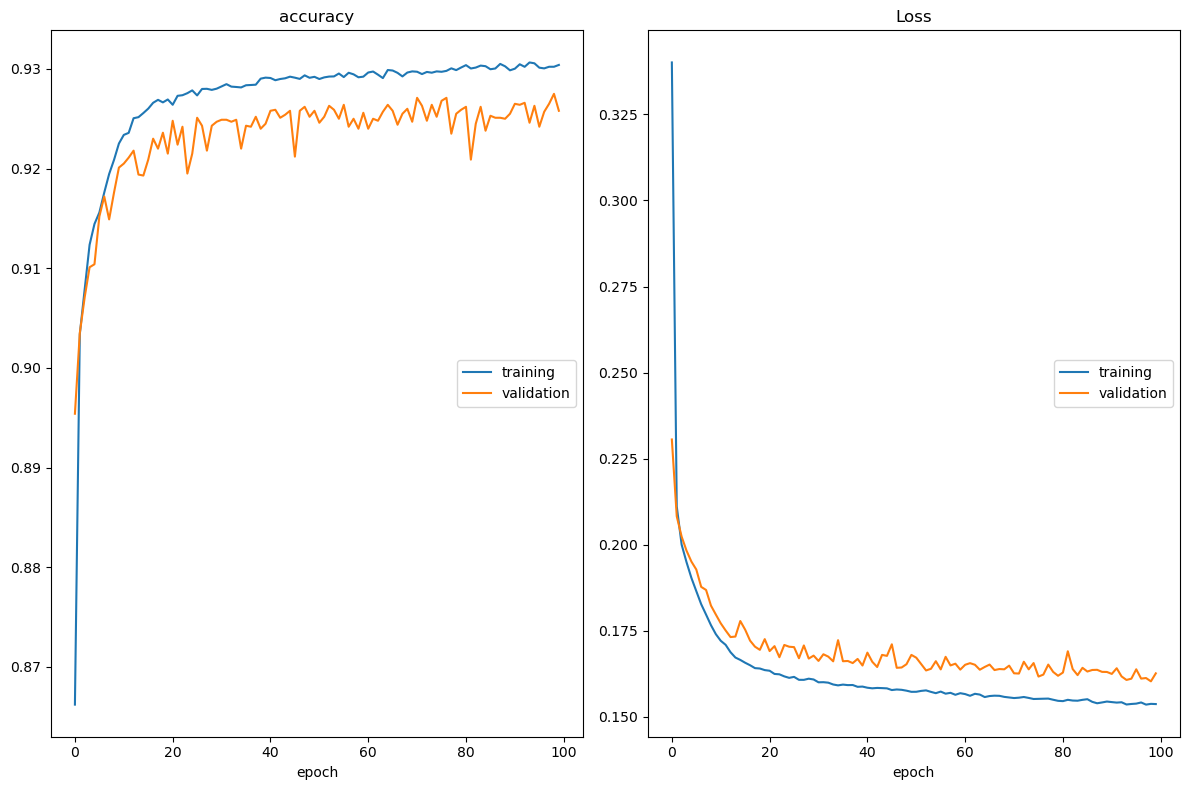

accuracy
	training         	 (min:    0.866, max:    0.931, cur:    0.930)
	validation       	 (min:    0.895, max:    0.928, cur:    0.926)
Loss
	training         	 (min:    0.153, max:    0.340, cur:    0.154)
	validation       	 (min:    0.160, max:    0.231, cur:    0.163)
197/197 - 1s - loss: 0.1537 - accuracy: 0.9304 - val_loss: 0.1626 - val_accuracy: 0.9258 - 652ms/epoch - 3ms/step


In [34]:
EPOCHS = 100
BATCH_SIZE = 1000

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=BATCH_SIZE)

history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    verbose=2,
                    callbacks=[PlotLossesKeras(), cp_callback])

In [35]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape((y_pred.shape[0],))

1611/1611 [==============================] - 1s 862us/step


In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred.round())
cm = np.around(cm / cm.astype('float').sum(axis=1, keepdims=True), decimals=3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(list(labels.unique())))

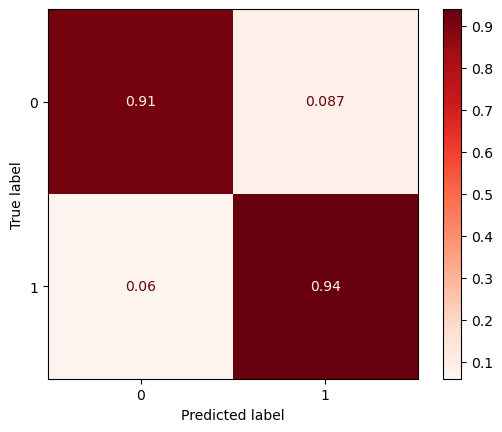

In [37]:
import matplotlib.pyplot as plt

disp.plot(cmap=plt.cm.Reds)

In [38]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score, f1_score

ys = y_test
ys_pred = y_pred.round()

print(f"Accuracy score:                   {accuracy_score(ys, ys_pred)}")
print(f"Matthews correlation coefficient: {matthews_corrcoef(ys, ys_pred)}")
print(f"recall score (weighted):          {recall_score(ys, ys_pred)}")
print(f"precision score (weighted):       {precision_score(ys, ys_pred)}")
print(f"f1 score (weighted):              {f1_score(ys, ys_pred)}")


Accuracy score:                   0.9304356262734064
Matthews correlation coefficient: 0.8501260723957063
recall score (weighted):          0.9403834449178332
precision score (weighted):       0.9500107602914502
f1 score (weighted):              0.9451725878232676


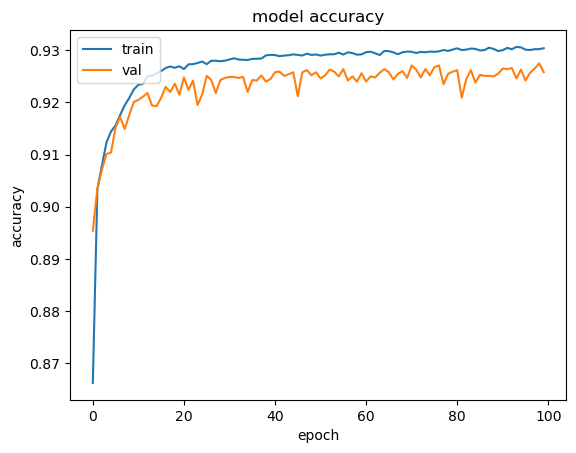

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

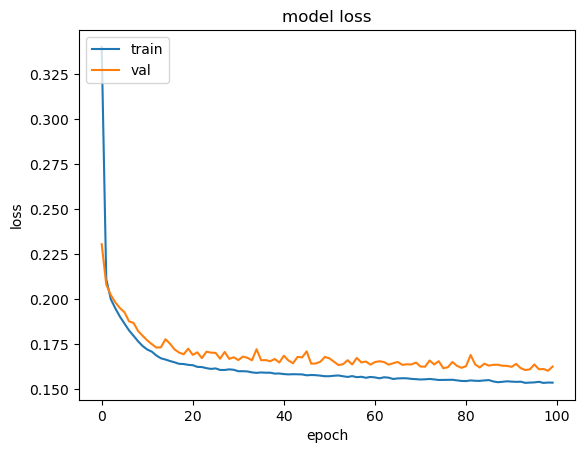

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Multi-class model

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df, pd.get_dummies(mc_labels), test_size=.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((206138, 24), (51535, 24), (206138, 10), (51535, 10))

In [42]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train.iloc[:, :n_num_cols] = sc.fit_transform(X_train.iloc[:, :n_num_cols])
X_test.iloc[:, :n_num_cols] = sc.transform(X_test.iloc[:, :n_num_cols])

In [43]:
X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

print(f"Training dataset:   {(X_train.shape, y_train.shape)}")
print(f"validation dataset: {(X_val.shape, y_val.shape)}")

Training dataset:   ((196138, 24), (196138, 10))
validation dataset: ((10000, 24), (10000, 10))


In [44]:
def create_multiclass_model():
    model = keras.Sequential(
        [
            layers.Dense(100, activation='relu', input_dim=X_train.shape[1]),
            layers.Dense(100, activation='relu', use_bias=True),
            layers.Dense(100, activation='relu', use_bias=True),
            layers.Dense(100, activation='relu', use_bias=True),
            layers.Dense(10, activation='softmax', use_bias=True)
        ]
    )
    model.compile('adam', loss='categorical_crossentropy', metrics='accuracy')
    return model

model = create_multiclass_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               2500      
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 10)                1010      
                                                                 
Total params: 33,810
Trainable params: 33,810
Non-trainable params: 0
_________________________________________________________________


In [45]:
import os

checkpoint_path = "../models/model_dnn_mc_kmeans.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

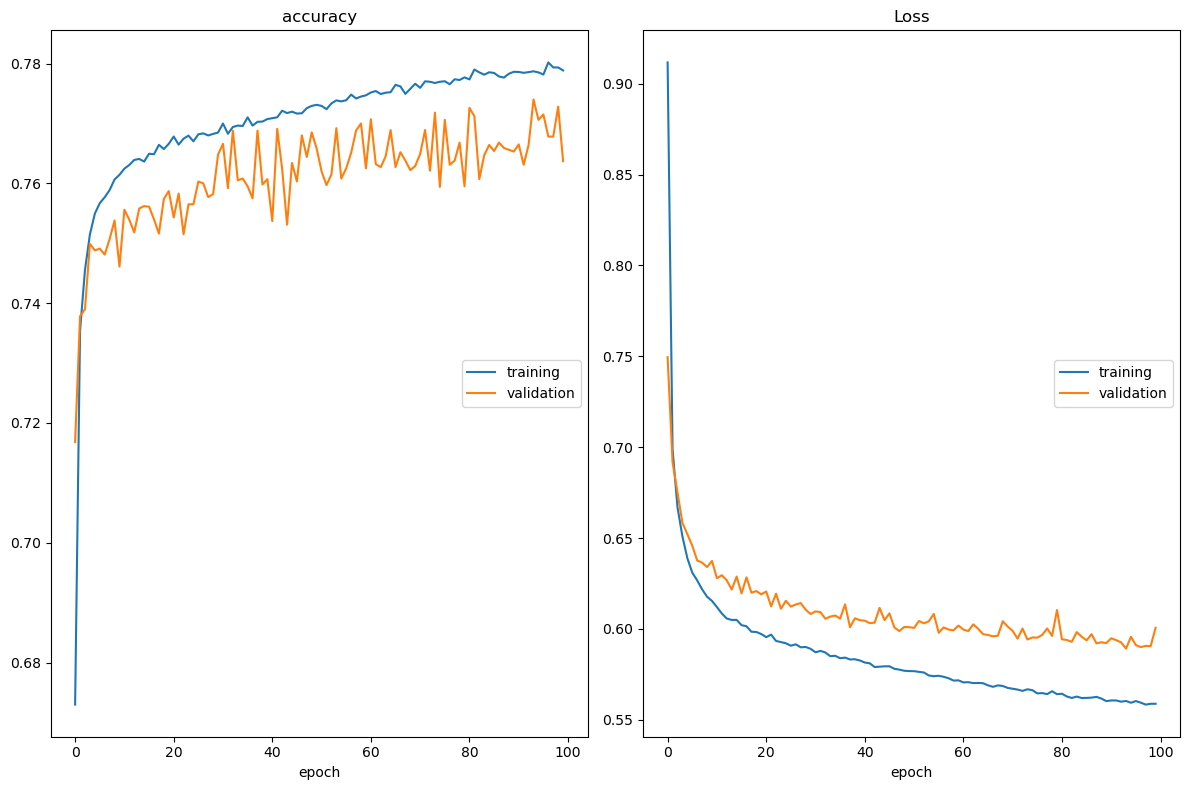

accuracy
	training         	 (min:    0.673, max:    0.780, cur:    0.779)
	validation       	 (min:    0.717, max:    0.774, cur:    0.764)
Loss
	training         	 (min:    0.558, max:    0.912, cur:    0.559)
	validation       	 (min:    0.589, max:    0.750, cur:    0.601)
197/197 - 1s - loss: 0.5588 - accuracy: 0.7788 - val_loss: 0.6006 - val_accuracy: 0.7637 - 1s/epoch - 6ms/step


In [46]:
EPOCHS = 100
BATCH_SIZE = 1000

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=BATCH_SIZE)

history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    verbose=2,
                    callbacks=[PlotLossesKeras(), cp_callback])

In [47]:
y_pred = model.predict(X_test)

1611/1611 [==============================] - 2s 1ms/step


In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.to_numpy().argmax(axis=1), y_pred.argmax(axis=1))
cm = np.around(cm / cm.astype('float').sum(axis=1, keepdims=True), decimals=3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(list(mc_labels.unique())))

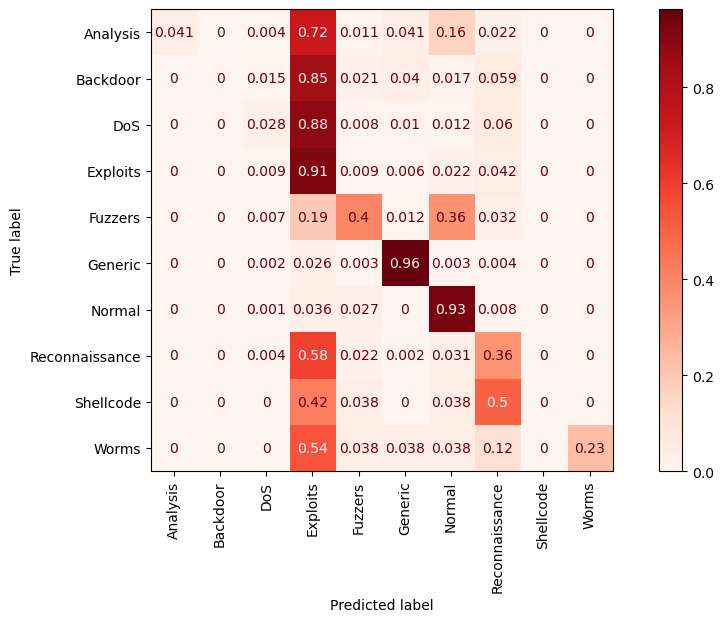

In [49]:
plt.rcParams["figure.figsize"] = (12,6)
disp.plot(cmap=plt.cm.Reds, xticks_rotation=90)

In [50]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score, f1_score, auc

ys = y_test.to_numpy().argmax(axis=1)
ys_pred = y_pred.argmax(axis=1)

print(f"Accuracy score:                   {accuracy_score(ys, ys_pred)}")
print(f"Matthews correlation coefficient: {matthews_corrcoef(ys, ys_pred)}")
print(f"recall score (weighted):          {recall_score(ys, ys_pred, average='weighted')}")
print(f"precision score (weighted):       {precision_score(ys, ys_pred, average='weighted')}")
print(f"f1 score (weighted):              {f1_score(ys, ys_pred, average='weighted')}")

Accuracy score:                   0.7721548462210148
Matthews correlation coefficient: 0.7081598477182687
recall score (weighted):          0.7721548462210148
precision score (weighted):       0.7622918463580289
f1 score (weighted):              0.7399238348679249


c:\Users\baljanj\Anaconda3\envs\ktai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
